# Computing Distance to Default
Mitchell Kramer

## Import Libs and Functions

In [ ]:
import pandas as pd

import statsmodels.api as sm    

import matplotlib.pyplot as plt

import numpy as np

import plotly.express as px

from scipy.stats import norm

from scipy.optimize import root

from scipy.optimize import fsolve

import plotly.graph_objs as go

import plotly.offline as pyo

pd.options.mode.chained_assignment = None

In [ ]:
def compute_dd_naive(row, v_val = None, sigma_val = None):
    
    """
    Compute the distance-to-default for different debt volatility values.

    Parameters:
    E (float): Market asset value.
    D (float): Face value of debt.
    sigma_e (float): Equity volatility.
    RF (float): Risk-free rate.
    T (float): Time horizon (default is 1 year).

    Returns:
    tuple: Distance-to-default for three different debt volatility scenarios.
    """    
    e = row['E']  # market asset value
    f = row['F']   # face value of debt
    rf = row['RF']  #risk-free rate
    sigma_e = row['sigma_e']
    t = 1  # Time horizon assumed to be 1 year
    if v_val is None:
        v = e + f
    else:
        v = row[v_val]
    sigmad = [0.05 + 0.25 * sigma_e, 0.05 + 0.5 * sigma_e, 0.25 * sigma_e]
    if sigma_val is None:
        sigmav = [np.divide(e , (e + f), out = np.zeros_like(e), where = (e+f) !=0) * sigma_e + (f / (e + f)) * sd for sd in sigmad]
        denominator = [sv * np.sqrt(t) for sv in sigmav]
        if f == 0:
            numerator = [rf + 0.5 * sv**2 * t for sv in sigmav]
        else:
            numerator = [np.log(v / f) + (rf + 0.5 * sv**2) * t for sv in sigmav]
        return [num / den for num, den in zip(numerator, denominator)]
    else:
        sigmav = row[sigma_val]
        numerator = np.divide(v , f, out = np.zeros_like(e), where = (f) !=0) * sigma_e + (f / (e + f)) + (rf + 0.5 * sigmav **2) * t
        denominator = sigmav * np.sqrt(t)
        return np.divide(numerator , denominator, out = np.zeros_like(numerator), where = (denominator) !=0) 
    
    

def compute_dd_direct(row):
    e = row['E']  # market asset value
    f = row['F']   # face value of debt
    rf = row['RF']  #risk-free rate
    sigma_e = row['sigma_e']
    t = 1  # Time horizon assumed to be 1 year
    
    def equations(p):
        V, sigma_V = p
        if f > 0:
            d1 = (np.log(V / f) + (rf + sigma_V**2 / 2) * t) / (sigma_V * np.sqrt(t)) 
        else:
            d1 = (rf + sigma_V**2 / 2) * t / (sigma_V * np.sqrt(t)) 

        d2 = d1 - sigma_V * np.sqrt(t)
        return (V * norm.cdf(d1) - np.exp(-rf * t) * f * norm.cdf(d2) - e, 
                V / e * norm.cdf(d1) * sigma_V - sigma_e)

    # Initial guesses for V and sigma_V
    initial_guesses = [e, sigma_e]
    solution = root(equations, initial_guesses)

    if solution.success:
        return solution.x
    else:
        return np.nan, np.nan
        #raise ValueError("Root finding did not converge")
    
def kmv_iterative(row, tol=1e-6, max_iter=1000):
    
    e = row['E']  # market asset value
    f = row['F']   # face value of debt
    rf = row['RF']  #risk-free rate
    sigma_e = row['sigma_e']
    t = 1  # Time horizon assumed to be 1 year
    """
    Iteratively solve for V (firm value) and sigma_V (asset volatility) using the KMV model.

    Parameters:
    e (float): Market value of equity.
    F (float): Face value of debt.
    r (float): Risk-free interest rate.
    sigma_e (float): Volatility of equity.
    T (float): Time horizon, typically 1 year.
    tol (float): Tolerance for convergence of sigma_V.
    max_iter (int): Maximum number of iterations.

    Returns:
    V (float): Estimated firm value.
    sigma_V (float): Estimated asset volatility.
    """
    # Initial guess for sigma_V (can be refined)
    sigma_V = sigma_e
    
    for _ in range(max_iter):
        # Solve for V using the equity option equation
        if f > 0:
            d1 = (np.log(e / f) + (rf + sigma_V**2 / 2) * t) / (sigma_V * np.sqrt(t)) 
        else:
            d1 = (rf + sigma_V**2 / 2) * t / (sigma_V * np.sqrt(t)) 
        d2 = d1 - sigma_V * np.sqrt(t)
        V = e + np.exp(-rf * t) * f * norm.cdf(-d2)

        # Estimate new sigma_V using the time series of V (here, a proxy estimate)
        new_sigma_V = sigma_e * (e / V)

        # Check for convergence
        if np.abs(new_sigma_V - sigma_V) < tol:
            return V, new_sigma_V
        
        # Update sigma_V for the next iteration
        sigma_V = new_sigma_V

    # If convergence is not reached, raise an exception
    #raise ValueError(f"No convergence after {max_iter} iterations.")
    return np.nan, np.nan


def compute_pd(row, dd_col = None):
    if dd_col is not None:
        DD = row[dd_col]
    else:
        DD = row['DD']
    return 1 - norm.cdf(DD)

## Data Extraction and Cleaning

In [ ]:
#Read CSV files in
compustat_raw = pd.read_csv('./funda_2022.csv', usecols = ['cusip', 'fyear', 'dlc', 'dltt', 'indfmt', 'datafmt', 'popsrc', 'consol', 'fic', 'datadate'])

daily_df_raw = pd.read_csv('mrvqyemh5sxhlkvc.csv', usecols = [ 'date', 'VOL', 'RET', 'vwretd',  'PRC', 'SHROUT',  'CUSIP']) #'HSICCD'

interest_rates = pd.read_csv('DAILYFED.csv')
interest_rates['DTB3'] = pd.to_numeric(interest_rates['DTB3'], errors = 'coerce')

In [ ]:
##BAA-FFM and Recession data clean and load
baaffm = pd.read_csv('BAAFFM.csv')
baaffm['DATE'] = pd.to_datetime(baaffm['DATE'])
baaffm['YEAR'] = baaffm['DATE'].dt.year
baaffm = baaffm[baaffm['YEAR'] >= 1970]
baaffm = baaffm.sort_values(by = 'DATE')
baaffm = baaffm.groupby('YEAR')['BAAFFM'].first()
baaffm = baaffm.reset_index()

nber = pd.read_csv('USREC.csv')
nber['DATE'] = pd.to_datetime(nber['DATE'])
nber['YEAR'] = nber['DATE'].dt.year
nber = nber[nber['YEAR'] >= 1970]
nber = nber.sort_values(by = 'DATE')
nber = nber.groupby('YEAR')['USREC'].first()
nber = nber.reset_index()

In [ ]:

# Filter the Compustat data based on the specified conditions
filtered_df = compustat_raw[
    (compustat_raw['indfmt'] == 'INDL') &
    (compustat_raw['datafmt'] == 'STD') &
    (compustat_raw['popsrc'] == 'D') &
    (compustat_raw['fic'] == 'USA') &
    (compustat_raw['consol'] == 'C') &
    (compustat_raw['fyear'] >= 1970) &
    (compustat_raw['fyear'] <= 2020)
]

# Process the required variables
# Extract first 6 characters of the cusip
filtered_df['cusip'] = filtered_df['cusip'].str[0:6]

filtered_df['YEAR'] = pd.to_datetime(filtered_df['datadate']).dt.year

# Multiply DLC and dltt by 1,000,000
filtered_df['dlc'] = filtered_df['dlc'] * 1000000
filtered_df['dltt'] = filtered_df['dltt'] * 1000000

# Compute Face value of debt (F) as DLC + 0.5 * dltt
filtered_df['F'] = filtered_df['dlc'] + 0.5 * filtered_df['dltt']

# The final DataFrame will have cusip, YEAR, and Default Boundary (F)
cpstat_final = filtered_df[['cusip', 'YEAR', 'F']]

#create a list of unique cusips to make sure that there is a match in the compustat data
compustat_cusip = list(set(cpstat_final['cusip']))

#cpstat_final

In [ ]:
#Data Cleaning and Load
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates['YEAR'] = interest_rates['DATE'].dt.year

daily_df_raw['CUSIP'] = daily_df_raw['CUSIP'].str[0:6]

daily_df = daily_df_raw[daily_df_raw['CUSIP'].isin(compustat_cusip)]
daily_df['date'] = pd.to_datetime(daily_df_raw['date'], errors='coerce')
daily_df['YEAR'] = daily_df['date'].dt.year


In [ ]:
# Sample 200 Firms from each year, starting with 1970, for efficiency, and then confirm their presence in the compustat data
unique_cusips = daily_df.groupby('YEAR')['CUSIP'].unique()

# Sample 200,100 CUSIPs per year
sampled_cusips_200 = unique_cusips.apply(lambda x: np.random.choice(x, min(len(x), 200), replace=False))
sampled_cusips_100 = unique_cusips.apply(lambda x: np.random.choice(x, min(len(x), 100), replace=False))

sampled_cusips_df_200 = pd.DataFrame(
    [(year, cusip) for year, cusips in sampled_cusips_200.items() for cusip in cusips],
    columns=['YEAR', 'CUSIP']
)

sampled_cusips_df_100 = pd.DataFrame(
    [(year, cusip) for year, cusips in sampled_cusips_100.items() for cusip in cusips],
    columns=['YEAR', 'CUSIP']
)

sampled_cusips_df_200

In [ ]:
# Filter the original DataFrame
sampled_df_200 = pd.merge(daily_df, sampled_cusips_df_200, on = ['YEAR', 'CUSIP'])
sampled_df_100 = pd.merge(daily_df, sampled_cusips_df_100, on = ['YEAR', 'CUSIP'])
sampled_df_200 = sampled_df_200.reset_index(drop=True)
sampled_df_100 = sampled_df_100.reset_index(drop=True)

#Adjust SHROUT
sampled_df_200['SHROUT'] = sampled_df_200['SHROUT'] * 1000
sampled_df_100['SHROUT'] = sampled_df_200['SHROUT'] * 1000
# Compute market capitalization E
sampled_df_200['E'] = np.abs(sampled_df_200['PRC']) * sampled_df_200['SHROUT']
sampled_df_200['RET'] = pd.to_numeric(sampled_df_200['RET'],  errors = 'coerce')
sampled_df_100['E'] = np.abs(sampled_df_100['PRC']) * sampled_df_100['SHROUT']
sampled_df_100['RET'] = pd.to_numeric(sampled_df_100['RET'],  errors = 'coerce')


In [ ]:
annret = sampled_df_200.groupby(['CUSIP', 'YEAR']).apply(lambda x: np.exp(np.sum(np.log(1 + x['RET']))))

annret_100 = sampled_df_100.groupby(['CUSIP', 'YEAR']).apply(lambda x: np.exp(np.sum(np.log(1 + x['RET']))))

sigmae = sampled_df_200.groupby(['CUSIP', 'YEAR']).apply(lambda x: x['RET'].std() * np.sqrt(250))
sigmae_100 = sampled_df_200.groupby(['CUSIP', 'YEAR']).apply(lambda x: x['RET'].std() * np.sqrt(250))

E = sampled_df_200.groupby(['CUSIP', 'YEAR'])['E'].first()
E_100 = sampled_df_100.groupby(['CUSIP', 'YEAR'])['E'].first()

In [ ]:
# Step 1: Calculate daily compounded returns
interest_rates['RF'] = np.log(1 + interest_rates['DTB3'] / 100)
# Group by YEAR and select the first value of cumulative return
riskfree = interest_rates.groupby('YEAR')['RF'].first()


# Join the series together
merged_df = annret.to_frame('annual_return').join(
    [sigmae.to_frame('sigma_e'), E.to_frame('E')], how='outer'
)
merged_df.reset_index(inplace = True)
merged_df['annual_return'] = merged_df['annual_return'].shift(1)
merged_df['sigma_e'] = merged_df['sigma_e'].shift(1)

merged_df2 = pd.merge(merged_df, riskfree, left_on = 'YEAR', right_on = 'YEAR', how = 'left')




In [ ]:
#Compute Distance to Default (Naive, with 3 different models for sigma d

final_df = pd.merge(merged_df2, cpstat_final, left_on = ('CUSIP','YEAR'), right_on = ('cusip','YEAR'), how = 'left')

final_df[['DD_NAIVE1', 'DD_NAIVE2', 'DD_NAIVE3']] = final_df.apply(compute_dd_naive, axis=1, result_type = 'expand')

final_df['PD_NAIVE1'] = final_df.apply(compute_pd, dd_col = 'DD_NAIVE1', axis=1)
final_df['PD_NAIVE2'] = final_df.apply(compute_pd, dd_col = 'DD_NAIVE2', axis=1)
final_df['PD_NAIVE3'] = final_df.apply(compute_pd, dd_col = 'DD_NAIVE3', axis=1)

final_df[['V_DIRECT', 'sigma_v_DIRECT']] = final_df.apply(compute_dd_direct, axis = 1, result_type = 'expand')
final_df['DD_DIRECT'] = final_df.apply(compute_dd_naive, v_val = 'V_DIRECT', sigma_val = 'sigma_v_DIRECT', axis = 1)

final_df[['V_ITER', 'sigma_v_ITER']] = final_df.apply(kmv_iterative, axis = 1, result_type = 'expand') 
final_df['DD_ITER'] = final_df.apply(compute_dd_naive, v_val = 'V_ITER', sigma_val = 'sigma_v_ITER', axis = 1)

final_df.head()

In [ ]:
final_df['PD_DIRECT'] = final_df.apply(compute_pd, dd_col = 'DD_DIRECT', axis = 1)
final_df['PD_ITER'] = final_df.apply(compute_pd, dd_col = 'DD_ITER', axis = 1)

In [ ]:
# Merge final_df with baaffm on 'YEAR'
final_df = final_df.merge(baaffm, on='YEAR', how='left')

# Merge the result with nber on 'YEAR'
final_df = final_df.merge(nber, on='YEAR', how='left')

In [ ]:
final_df_recession = final_df[final_df['USREC'] == 1].loc[:, ['CUSIP', 'YEAR', 'RF', 'F',
       'DD_NAIVE1', 'DD_NAIVE2', 'DD_NAIVE3', 'PD_NAIVE1', 'PD_NAIVE2', 'V_DIRECT', 'DD_ITER', 'DD_DIRECT', 'PD_DIRECT', 'PD_ITER',
       'PD_NAIVE3', 'V_ITER', 'sigma_v_ITER', 'BAAFFM', 'USREC']]
final_df_no_recession = final_df[final_df['USREC'] != 1].loc[:, ['CUSIP', 'YEAR', 'RF', 'F',
       'DD_NAIVE1', 'DD_NAIVE2', 'DD_NAIVE3', 'PD_NAIVE1', 'PD_NAIVE2',
       'PD_NAIVE3', 'V_ITER', 'sigma_v_ITER', 'BAAFFM','V_DIRECT', 'DD_ITER', 'DD_DIRECT', 'PD_DIRECT', 'PD_ITER', 'USREC']]

In [ ]:
final_df.loc[:, ['CUSIP', 'YEAR', 'RF', 'F',
       'DD_NAIVE1', 'DD_NAIVE2', 'DD_NAIVE3', 'PD_NAIVE1', 'PD_NAIVE2',
       'PD_NAIVE3', 'V_ITER', 'sigma_v_ITER', 'BAAFFM', 'V_DIRECT', 'PD_DIRECT', 'PD_ITER',
       'USREC']].describe()


In [29]:
final_df_recession.describe()


,YEAR,RF,F,DD_NAIVE1,DD_NAIVE2,DD_NAIVE3,PD_NAIVE1,PD_NAIVE2,V_DIRECT,PD_DIRECT,PD_ITER,PD_NAIVE3,V_ITER,sigma_v_ITER,BAAFFM,USREC
count,443.000000,443.000000,3.000000e+02,290.000000,290.000000,290.000000,2.900000e+02,2.900000e+02,2.300000e+02,2.300000e+02,2.900000e+02,2.900000e+02,2.900000e+02,290.000000,443.000000,443.0
mean,2008.492099,0.016293,7.493756e+08,5.461133,5.290062,5.618748,7.174085e-02,7.723560e-02,2.792287e+09,7.188514e-02,5.705605e-02,6.858038e-02,2.664209e+09,0.502114,5.252415,1.0
std,0.500503,0.015268,3.846721e+09,7.366880,7.353233,7.458634,1.373732e-01,1.388818e-01,7.390199e+09,1.510293e-01,1.375502e-01,1.368844e-01,7.701807e+09,0.439248,2.697710,0.0
min,2008.000000,0.000800,0.000000e+00,0.046865,0.046865,0.046865,0.000000e+00,0.000000e+00,2.994306e+06,0.000000e+00,0.000000e+00,0.000000e+00,3.073538e+06,0.019031,2.600000,1.0
25%,2008.000000,0.000800,2.250500e+06,1.634217,1.420011,1.795717,2.275680e-13,4.522688e-12,1.193182e+08,0.000000e+00,0.000000e+00,1.387779e-14,9.224795e+07,0.237391,2.600000,1.0
50%,2008.000000,0.031305,3.346650e+07,3.583019,3.303306,3.735945,1.698314e-04,4.784621e-04,4.001831e+08,1.665335e-16,4.650963e-11,9.359818e-05,3.441831e+08,0.418436,2.600000,1.0
75%,2009.000000,0.031305,3.161322e+08,7.320009,6.825148,7.616295,5.110732e-02,7.781016e-02,1.951155e+09,1.420469e-08,2.529644e-04,3.628042e-02,1.516009e+09,0.618036,7.990000,1.0
max,2009.000000,0.031305,5.144950e+10,79.696304,79.451749,80.591037,4.813105e-01,4.813105e-01,6.302684e+10,4.813105e-01,4.813105e-01,4.813105e-01,5.899117e+10,4.671274,7.990000,1.0


In [30]:
final_df_no_recession.describe()

,YEAR,RF,F,DD_NAIVE1,DD_NAIVE2,DD_NAIVE3,PD_NAIVE1,PD_NAIVE2,PD_NAIVE3,V_ITER,sigma_v_ITER,BAAFFM,V_DIRECT,PD_DIRECT,PD_ITER,USREC
count,5856.000000,5856.000000,3.841000e+03,3740.000000,3740.000000,3740.000000,3.740000e+03,3.740000e+03,3.740000e+03,3.740000e+03,3740.000000,5856.000000,3.145000e+03,3.145000e+03,3.740000e+03,5856.0
mean,2009.252049,0.020490,7.315003e+08,6.200240,6.014588,inf,6.135756e-02,6.477620e-02,5.969053e-02,3.732732e+09,0.544353,3.728142,4.683886e+09,6.037264e-02,5.081249e-02,0.0
std,8.321753,0.020497,4.931087e+09,12.498152,12.459047,NaN,1.280578e-01,1.288941e-01,1.276145e-01,2.220496e+10,0.675044,1.508886,2.622167e+10,1.363157e-01,1.269178e-01,0.0
min,1995.000000,0.000200,0.000000e+00,0.080601,0.080601,0.080601,0.000000e+00,0.000000e+00,0.000000e+00,8.937099e+05,0.000000,1.090000,1.971349e+06,0.000000e+00,0.000000e+00,0.0
25%,2002.000000,0.000900,1.594000e+06,2.034834,1.835314,2.131782,1.324496e-13,8.762435e-13,2.037259e-14,8.763177e+07,0.251651,2.660000,1.092266e+08,0.000000e+00,0.000000e+00,0.0
50%,2011.000000,0.014100,3.339000e+07,3.993754,3.784245,4.207874,3.251775e-05,7.708814e-05,1.288943e-05,3.449190e+08,0.412036,3.550000,4.273463e+08,0.000000e+00,6.481304e-11,0.0
75%,2017.000000,0.042868,2.613125e+08,7.311096,7.052914,7.558408,2.093383e-02,3.322964e-02,1.651237e-02,1.440032e+09,0.674831,5.120000,1.800823e+09,1.690084e-09,1.619374e-04,0.0
max,2022.000000,0.055340,2.237310e+11,396.648982,396.648982,inf,4.678795e-01,4.678795e-01,4.678795e-01,7.469305e+11,21.161968,6.140000,8.076353e+11,5.000000e-01,5.000000e-01,0.0


In [26]:
graph_df = final_df.loc[:, ['YEAR', 'DD_NAIVE1', 'DD_NAIVE2', 'DD_NAIVE3', 'PD_NAIVE1', 'PD_NAIVE2', 'PD_NAIVE3', 'DD_DIRECT', 'PD_DIRECT', 'PD_ITER',  'DD_ITER', 'BAAFFM']].groupby('YEAR').describe()
graph_df.columns = ['_'.join(col).strip() for col in graph_df.columns.values]

# Reset index if you want 'YEAR' as a regular column
graph_df.reset_index(inplace=True)

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df is your DataFrame
# Replace 'group_names_y1' and 'group_names_y2' with the list of columns you want to plot on each y-axis
group_names_y1 = [col for col in graph_df.columns if 'DD' and '%' in col]  # Variables for the first y-axis
group_names_y2 = [col for col in graph_df.columns if 'PD' and '%' in col or 'BAA' and '%' in col ]  # Variables for the second y-axis

# Create a subplot with 2 y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces for the first group
for var in group_names_y1:
    fig.add_trace(
        go.Scatter(x=graph_df['YEAR'], y=graph_df[var], name=var),
        secondary_y=False,
    )

# Add traces for the second group
for var in group_names_y2:
    fig.add_trace(
        go.Scatter(x=graph_df['YEAR'], y=graph_df[var], name=var),
        secondary_y=True,
    )

# Update layout with titles and axis labels
fig.update_layout(
    title='Distance To Default, Probability, BAA-FFM Spread',
    xaxis_title='Year',
    hovermode='closest'
)

# Set y-axes titles
fig.update_yaxes(title_text='Distance to Default', secondary_y=False)
fig.update_yaxes(range = [0, 1], title_text='Probability to Default and BAA-FFM Spread', secondary_y=True)

highlight_years = final_df_recession['YEAR'].unique()  # Ensure unique years if there are duplicates

for year in highlight_years:
    fig.add_shape(
        type="rect",
        xref="x",
        yref="paper",
        x0=str(year),  # Convert year to string if it's an integer
        y0=0,
        x1=str(year + 1),  # Assuming you want to highlight the entire year
        y1=1,
        fillcolor="LightSkyBlue",
        opacity=0.5,
        layer="below",
        line_width=0,
    )
# Show the figure
fig.show()

### ***Please note that the graph above will not show when I export for some reason (despite being rendered on my computer), so I have snipped it and reattached it here 

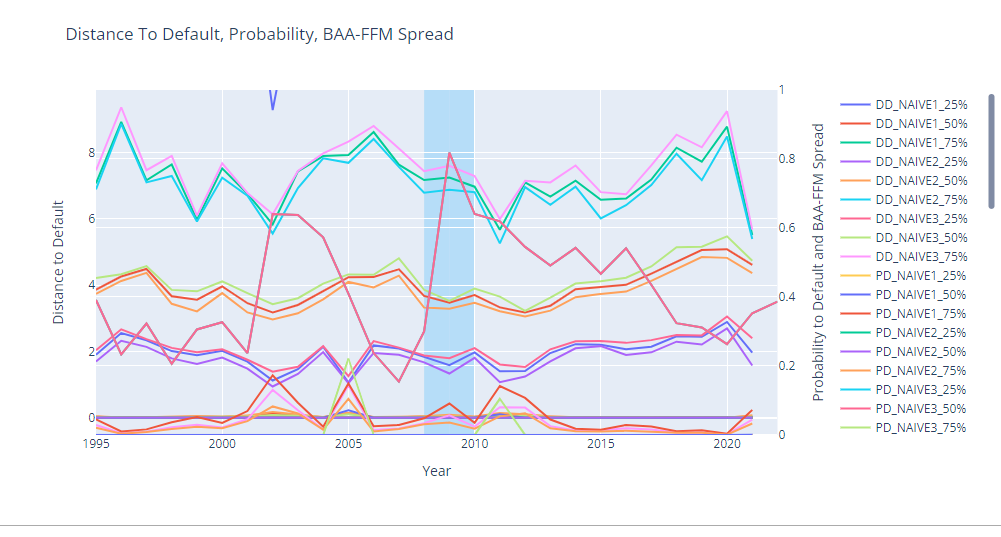

In [34]:
from IPython.display import Image
Image('./DD_graph.png')

## Analysis
- As expected, the sample data for receession years is much smaller than the dataset for the non-recession years
- Other intuitive observations derived from this analysis are: 
    - BAAFFM is far higher in the recession years than the non-recession (reflecting higher risk premium demanded in recession period)
    - Similarly, all computations of Distance To Default are lower in the recession years 
    - The pattern for most measures is inverse - higher probability of default is a lower distance to default
- Among the naive computations, the distance to default is generally decreasing with some constant added to the volatility of the debt (sigma d)
- The vertical spike in the graph appears to be a very clear depiction of the 2008 housing market crash, where value of equity collapsed and sharply decreased distance to default of many firms whose asset value collapsed overnight (also, the yearly data does not allow for enough points to smooth the curve
- The pattern I observe (and is possibly a key flaw of this way of calculating distance to default) is that the highest distance to default points appear to spike right before a recession/market crash - this is logically borne out by investors following a speculative bubble/bull market inflated market asset values
-  For the iterative and direct methods, it still finds probability of default to be much higher in a recession
- The pattern emerge